In [1]:
import pandas as pd
import functions as fn
import numpy as np
import matplotlib.pyplot as plt

# Constructing Synthetic Basket

1. Calculates the cointegration score of each NASDAQ100 component present in 2018 and 2019 against the QQQ ETF for the year 2018
2. Selects subset of NASDAQ100 components that have a cointegration p-value below 0.2
3. Create a powerset of the cointegrated subset and calculate the cointegration score of the subset against the QQQ ETF
4. Select most cointegrated subset as our synthetic basket which is, by design, cointegrated with QQQ in 2018

In [2]:
tickers = pd.read_csv("../data/nasdaq_comps_2016-2020.csv")

### Engle-Granger Two-Step Method
We use the Engle-Granger Two-Step method in our initial step to calculate the cointegration between each NASDAQ100 component and the QQQ ETF.  NASDAQ100 components are chosen if they are a component during both our basket formation period (2018) and our trading period (2019).

In [3]:
tickers = list(set(tickers['2019']).intersection(set(tickers['2018'])))
etf = 'QQQ'
start = '2018-01-01'
end = '2018-12-31'
cointegrationResultsIndividual = fn.runCointTestIndividual(etf, tickers, start, end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
MCHP
[*********************100%***********************]  1 of 1 completed
AAL
[*********************100%***********************]  1 of 1 completed
CDNS
[*********************100%***********************]  1 of 1 completed
LBTYA
[*********************100%***********************]  1 of 1 completed
WBA
[*********************100%***********************]  1 of 1 completed
FB
[*********************100%***********************]  1 of 1 completed
MNST
[*********************100%***********************]  1 of 1 completed
ADSK
[*********************100%***********************]  1 of 1 completed
BIIB
[*********************100%***********************]  1 of 1 completed
MYL
[*********************100%***********************]  1 of 1 completed
ROST
[*********************100%***********************]  1 of 1 completed
WYNN
[*********************100%*********************

In [4]:
cointegrationResultsIndividual.head(10)

,ticker,t-stat,pval
66,HAS,-3.476138,0.034570
30,AAPL,-3.268703,0.059170
23,TTWO,-3.186715,0.072178
27,IDXX,-3.156778,0.077458
38,SBUX,-3.125705,0.083256
46,CTAS,-3.089389,0.090454
63,ALXN,-2.892722,0.137956
90,ALGN,-2.865327,0.145781
57,BMRN,-2.797488,0.166485
72,PAYX,-2.703154,0.198446


### Synthetic Basket Construction
Based on the Engle-Granger cointegration test performed, we select the subset of the NASDAQ100 components that have a cointegration test p-value of less than 0.2 to be candidates for our synthetic basket.  We create every possible basket that can be constructed by any combination of the components in our subset and run another Engle-Granger cointegration test.  This time we run the cointegration test of the ETF against the sum of the components in our basket.  The most cointegrated synthetic basket is selected to be traded in the trading period (2019).

In [5]:
subset = cointegrationResultsIndividual.loc[cointegrationResultsIndividual['pval'] <= 0.2]
tickers = subset['ticker'].tolist()
etf = 'QQQ'
start = '2018-01-01'
end = '2018-12-31'
synthetic_asset_rank = fn.runCointTestBasketsEG(etf, tickers, start, end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  10 of 10 completed
0 done, out of a total of  1013
500 done, out of a total of  1013
1000 done, out of a total of  1013


In [6]:
synthetic_asset_rank.head()

,ticker,t-stat,pval
973,"(HAS, AAPL, TTWO, SBUX, CTAS, ALXN, ALGN, PAYX)",-5.112294,0.000102
857,"(HAS, AAPL, TTWO, SBUX, CTAS, ALXN, ALGN)",-5.082241,0.000116
972,"(HAS, AAPL, TTWO, SBUX, CTAS, ALXN, ALGN, BMRN)",-5.054691,0.000130
984,"(HAS, AAPL, SBUX, CTAS, ALXN, ALGN, BMRN, PAYX)",-5.047519,0.000135
1008,"(HAS, AAPL, TTWO, SBUX, CTAS, ALXN, ALGN, BMRN...",-5.047064,0.000135


# Constructing Multivariate Kalman Filter
1. Construct a multivariate Kalman Filter with each stock in our synthetic basket collectively filtered against QQQ for the year 2019
2. Using the outputted state means, calculate the value of our synthetic basket
3. Generate the spread between our synthetic basket and the QQQ ETF.  We expect this spread to be mean-reverting

In [7]:
# Start from 01-01-2019 and end at 12-31-2019
qqq = pd.read_csv("../data/qqqMinute2019.csv")
has = pd.read_csv("../data/hasMinute2019.csv")
aapl = pd.read_csv("../data/aaplMinute2019.csv")
ttwo = pd.read_csv("../data/ttwoMinute2019.csv")
sbux = pd.read_csv("../data/sbuxMinute2019.csv")
ctas = pd.read_csv("../data/ctasMinute2019.csv")
alxn = pd.read_csv("../data/alxnMinute2019.csv")
algn = pd.read_csv("../data/algnMinute2019.csv")
payx = pd.read_csv("../data/payxMinute2019.csv")

In [8]:
qqq = qqq.set_index('date_time')
qqq = qqq.rename(columns={'close': 'qqqclose'})

has = has.set_index('date_time')
has = has.rename(columns={'close': 'hasclose'})

aapl = aapl.set_index('date_time')
aapl = aapl.rename(columns={'close': 'aaplclose'})

ttwo = ttwo.set_index('date_time')
ttwo = ttwo.rename(columns={'close': 'ttwoclose'})

sbux = sbux.set_index('date_time')
sbux = sbux.rename(columns={'close': 'sbuxclose'})

ctas = ctas.set_index('date_time')
ctas = ctas.rename(columns={'close': 'ctasclose'})

alxn = alxn.set_index('date_time')
alxn = alxn.rename(columns={'close': 'alxnclose'})

algn = algn.set_index('date_time')
algn = algn.rename(columns={'close': 'algnclose'})

payx = payx.set_index('date_time')
payx = payx.rename(columns={'close': 'payxclose'})

data = qqq[['qqqclose']].join([has[['hasclose']], aapl[['aaplclose']], ttwo[['ttwoclose']], sbux[['sbuxclose']], 
                               ctas[['ctasclose']], alxn[['alxnclose']], algn[['algnclose']], payx[['payxclose']]], 
                              how='outer')
data = data.dropna()
data.tail(20)

,qqqclose,hasclose,aaplclose,ttwoclose,sbuxclose,ctasclose,alxnclose,algnclose,payxclose
2019-12-31 15:30:00,212.345,105.7300,293.1700,122.2000,87.6850,268.2800,108.0100,277.8000,84.8400
2019-12-31 15:31:00,212.330,105.7100,293.1768,122.1600,87.7050,268.3100,107.9500,277.5900,84.8500
2019-12-31 15:32:00,212.355,105.6972,293.1400,122.1200,87.7130,268.3200,107.9500,277.8300,84.8600
2019-12-31 15:33:00,212.360,105.6900,293.0200,122.1800,87.7250,268.4400,107.9550,277.8800,84.8700
2019-12-31 15:34:00,212.365,105.6900,293.0165,122.2200,87.7700,268.4900,107.9700,277.8200,84.8900
2019-12-31 15:35:00,212.385,105.6800,293.0170,122.1800,87.7650,268.4800,107.9850,278.1000,84.9100
2019-12-31 15:36:00,212.370,105.6500,292.9450,122.2000,87.7600,268.4793,108.0387,278.0950,84.8800
2019-12-31 15:37:00,212.350,105.6200,293.0400,122.1700,87.7600,268.4900,107.9800,277.8700,84.8800
2019-12-31 15:38:00,212.385,105.6200,293.1316,122.1298,87.7600,268.5600,108.0000,278.1000,84.9000
2019-12-31 15:39:00,212.355,105.6044,293.0800,122.1050,87.7500,268.5800,108.0300,278.0050,84.9300


In [9]:
syntheticAssetLogPrice = data[['hasclose', 'aaplclose', 'ttwoclose', 'sbuxclose', 
                               'ctasclose', 'alxnclose', 'algnclose', 'payxclose']].apply(np.log)
qqqLogPrice = np.log(data['qqqclose'].values)

### Multivariate Kalman Filter
At every timestep, the Kalman Filter outputs estimates for the hedge ratios of each component in our synthetic basket as well as an intercept term.  In other words, it gave us all the tools to calculate an estimate for the price of QQQ based on the price of each component in our basket.  The residuals of this estimate form a mean-reverting and stationary process that we can take advantage of.  

In [10]:
kf = fn.multivariateKalmanFilter(syntheticAssetLogPrice, qqqLogPrice)
state_means, state_covs = kf.filter(qqqLogPrice)
basket_size = len(syntheticAssetLogPrice.columns)
slopes = state_means[:, np.arange(0, basket_size, 1)]
#print(slopes[0])
#intercept = state_means[:, basket_size]

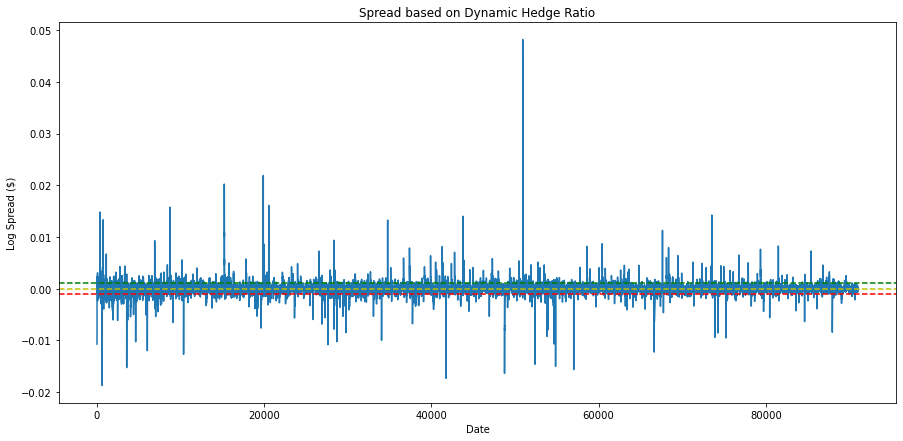

In [11]:
syntheticAssetEstimate = [np.dot(slopes[i], syntheticAssetLogPrice.values[i].T) for i in range(len(slopes))]
spread_ts = qqqLogPrice - syntheticAssetEstimate
plt.figure(figsize = (15,7))
plt.plot(spread_ts)
plt.title("Spread based on Dynamic Hedge Ratio")
plt.ylabel("Log Spread ($)")
plt.xlabel("Date")
spread_avg = spread_ts.mean()
spread_sd = spread_ts.std()
upper_threshold = spread_avg + spread_sd
lower_threshold = spread_avg - spread_sd
plt.axhline(upper_threshold, linestyle = 'dashed', color = 'g')
plt.axhline(spread_avg, linestyle = 'dashed', color = 'y')
plt.axhline(lower_threshold, linestyle = 'dashed', color = 'r')

# Building our Strategy
1. Using minute level data from 2018, optimize our strategy parameters by simulating the strategy performance in 2018 with different parameter combinations.  Pick the parameters that give us the highest return in 2018 and use those parameters for our strategy in 2019.
2. Build a Bollinger Band strategy using the lookback and z-score threshold outputted by our parameter tuning module.  When the spread breaks above/below our upper/lower bands, we enter a short/long position on the spread in the minute immediately after.

In [12]:
# Start from 01-01-2018 and end at 12-31-2018
qqq2018 = pd.read_csv("../data/qqqMinute2018.csv")
has2018 = pd.read_csv("../data/hasMinute2018.csv")
aapl2018 = pd.read_csv("../data/aaplMinute2018.csv")
ttwo2018 = pd.read_csv("../data/ttwoMinute2018.csv")
sbux2018 = pd.read_csv("../data/sbuxMinute2018.csv")
ctas2018 = pd.read_csv("../data/ctasMinute2018.csv")
alxn2018 = pd.read_csv("../data/alxnMinute2018.csv")
algn2018 = pd.read_csv("../data/algnMinute2018.csv")
payx2018 = pd.read_csv("../data/payxMinute2018.csv")

In [13]:
qqq2018 = qqq2018.set_index('date_time')
qqq2018 = qqq2018.rename(columns={'close': 'qqqclose'})

has2018 = has2018.set_index('date_time')
has2018 = has2018.rename(columns={'close': 'hasclose'})

aapl2018 = aapl2018.set_index('date_time')
aapl2018 = aapl2018.rename(columns={'close': 'aaplclose'})

ttwo2018 = ttwo2018.set_index('date_time')
ttwo2018 = ttwo2018.rename(columns={'close': 'ttwoclose'})

sbux2018 = sbux2018.set_index('date_time')
sbux2018 = sbux2018.rename(columns={'close': 'sbuxclose'})

ctas2018 = ctas2018.set_index('date_time')
ctas2018 = ctas2018.rename(columns={'close': 'ctasclose'})

alxn2018 = alxn2018.set_index('date_time')
alxn2018 = alxn2018.rename(columns={'close': 'alxnclose'})

algn2018 = algn2018.set_index('date_time')
algn2018 = algn2018.rename(columns={'close': 'algnclose'})

payx2018 = payx2018.set_index('date_time')
payx2018 = payx2018.rename(columns={'close': 'payxclose'})

data2018 = qqq2018[['qqqclose']].join([has2018[['hasclose']], aapl2018[['aaplclose']], ttwo2018[['ttwoclose']], 
                                       sbux2018[['sbuxclose']], ctas2018[['ctasclose']], alxn2018[['alxnclose']], 
                                       algn2018[['algnclose']], payx2018[['payxclose']]], 
                                      how='outer')
data2018 = data2018.dropna()

In [14]:
syntheticAssetLogPrice2018 = data2018[['hasclose', 'aaplclose', 'ttwoclose', 'sbuxclose', 
                               'ctasclose', 'alxnclose', 'algnclose', 'payxclose']].apply(np.log)
qqqLogPrice2018 = np.log(data2018['qqqclose'].values)

In [15]:
kf2018 = fn.multivariateKalmanFilter(syntheticAssetLogPrice2018, qqqLogPrice2018)
state_means2018, state_covs2018 = kf2018.filter(qqqLogPrice2018)
basket_size2018 = len(syntheticAssetLogPrice2018.columns)
slopes2018 = state_means2018[:, np.arange(0, basket_size2018, 1)]
#intercept2018 = state_means2018[:, basket_size2018]

In [16]:
hedge_ratios2018 = np.asarray([slopes2018.T[i] for i in range(len(slopes2018.T))]).T
hedge_ratios2018 = pd.DataFrame(hedge_ratios2018, columns=['hasclose', 'aaplclose', 'ttwoclose', 'sbuxclose', 
                      'ctasclose', 'alxnclose', 'algnclose', 'payxclose'])
#hedge_ratios2018['intercept'] = intercept2018

In [17]:
#hedge_ratios2018.to_csv("../hedge_ratios_2018.csv")

In [18]:
syntheticAssetEstimate2018 = [np.dot(slopes2018[i], syntheticAssetLogPrice2018.values[i].T)
                              for i in range(len(slopes2018))]
spread_ts2018 = qqqLogPrice2018 - syntheticAssetEstimate2018
data2018.reset_index(inplace=True)
data2018 = data2018.rename(columns={'index': 'datetime'})
data2018['logspread'] = spread_ts2018
data2018['spread'] = np.exp(spread_ts2018)
backtest_data2018 = data2018[['datetime', 'qqqclose', 'hasclose', 'aaplclose', 'ttwoclose', 'sbuxclose', 
                      'ctasclose', 'alxnclose', 'algnclose', 'payxclose', 'spread']]
diff_thresh = fn.calculateDiffThresh(backtest_data2018, q=0.2)

In [19]:
print(diff_thresh)

0.006773079365496303


In [20]:
### OU Process
ou_data = pd.DataFrame(backtest_data2018['qqqclose'].apply(np.log))
ou_data['synth'] = [np.dot(slopes2018[i], syntheticAssetLogPrice2018.values[i].T) for i in range(len(slopes2018))]
#ou_data = ou_data.apply(np.exp)
ou_data

,qqqclose,synth
0,5.055035,5.065738
1,5.055545,5.060666
2,5.056023,5.059323
3,5.056118,5.058206
4,5.056182,5.058470
...,...,...
88322,5.035588,5.036027
88323,5.035458,5.035660
88324,5.034873,5.035005
88325,5.034189,5.034308


In [21]:
import scipy.optimize as so
from math import sqrt, exp, log, pi

def compute_log_likelihood(params, *args):
    '''
    Compute the average Log Likelihood, this function will by minimized by scipy.
    Find in (2.2) in linked paper

    returns: the average log likelihood from given parameters
    '''
    # functions passed into scipy's minimize() needs accept one parameter, a tuple of
    #   of values that we adjust to minimize the value we return.
    #   optionally, *args can be passed, which are values we don't change, but still want
    #   to use in our function (e.g. the measured heights in our sample or the value Pi)

    theta, mu, sigma = params
    X, dt = args
    n = len(X)

    sigma_tilde_squared = sigma ** 2 * (1 - exp(-2 * mu * dt)) / (2 * mu)
    summation_term = 0

    for i in range(1, len(X)):
        summation_term += (X[i] - X[i - 1] * exp(-mu * dt) - theta * (1 - exp(-mu * dt))) ** 2

    summation_term = -summation_term / (2 * n * sigma_tilde_squared)

    log_likelihood = (-log(2 * pi) / 2) + (-log(sqrt(sigma_tilde_squared))) + summation_term

    return -log_likelihood
    # since we want to maximize this total log likelihood, we need to minimize the
    #   negation of the this value (scipy doesn't support maximize)


def estimate_coefficients_MLE(X, dt, tol=1e-10):
    '''
    Estimates Ornstein-Uhlenbeck coefficients (θ, µ, σ) of the given array
    using the Maximum Likelihood Estimation method

    input: X - array-like time series data to be fit as an OU process
           dt - time increment (1 / days(start date - end date))
           tol - tolerance for determination (smaller tolerance means higher precision)
    returns: θ, µ, σ, Average Log Likelihood
    '''

    bounds = ((None, None), (1e-5, None), (1e-5, None))  # theta ∈ ℝ, mu > 0, sigma > 0
                                                           # we need 1e-10 b/c scipy bounds are inclusive of 0, 
                                                           # and sigma = 0 causes division by 0 error
    theta_init = np.mean(X)
    initial_guess = (theta_init, 100, 100)  # initial guesses for theta, mu, sigma
    result = so.minimize(compute_log_likelihood, initial_guess, args=(X, dt), bounds=bounds, tol=tol)
    theta, mu, sigma = result.x 
    max_log_likelihood = -result.fun  # undo negation from __compute_log_likelihood
    # .x gets the optimized parameters, .fun gets the optimized value
    return theta, mu, sigma, max_log_likelihood

In [22]:
def compute_portfolio_values(ts_A, nameA, ts_B, namesB, slopes, beta):
    '''
    Compute the portfolio values over time when holding $1 of stock A 
    and -$alloc_B of stock B
    
    input: ts_A - time-series of price data of stock A,
           ts_B - time-series of price data of stock B
    outputs: Portfolio values of holding $1 of stock A and -$alloc_B of stock B
    '''
    
    ts_A = ts_A.copy()  # defensive programming
    ts_B = ts_B.copy()
    ts_A[nameA] = ts_A[nameA] / ts_A[nameA].iloc[0]
    prices = slopes[namesB].multiply(ts_B[namesB])
    asset_price = prices.sum(1)
    base = slopes[namesB].iloc[0].multiply(ts_B[namesB].iloc[0])
    ts_B["syntheticAsset"] = asset_price / base.sum()
    return ts_A[nameA] - beta * ts_B["syntheticAsset"]

In [23]:
def arg_max_B_alloc(ts_A, nameA, ts_B, namesB, slopes, dt):
    '''
    Finds the $ allocation ratio to stock B to maximize the log likelihood
    from the fit of portfolio values to an OU process

    input: ts_A - time-series of price data of stock A,
           ts_B - time-series of price data of stock B
           dt - time increment (1 / days(start date - end date))
    returns: θ*, µ*, σ*, B*
    '''
    
    theta = mu = sigma = alloc_B = 0
    max_log_likelihood = 0

    def compute_coefficients(beta):
        portfolio_values = compute_portfolio_values(ts_A, nameA, ts_B, namesB, slopes, beta)
        print("SINGLE TS:", portfolio_values)
        coeffs = estimate_coefficients_MLE(portfolio_values, dt)
        print(coeffs)
        return coeffs
    vectorized = np.vectorize(compute_coefficients)
    linspace = 1#np.linspace(.01, 1, 100)
    res = vectorized(linspace)
    print(res)
    index = res[3].argmax()
    
    return res[0], res[1], res[2], linspace

In [24]:
qqq = backtest_data2018[["datetime", "qqqclose"]]
synth = backtest_data2018[['datetime', 'hasclose', 'aaplclose', 'ttwoclose', 'sbuxclose', 
                      'ctasclose', 'alxnclose', 'algnclose', 'payxclose']]

dt = 1.0 / len(qqq)
theta, mu, sigma, b_alloc = arg_max_B_alloc(qqq, "qqqclose", synth, 
                                            ['hasclose', 'aaplclose', 'ttwoclose', 'sbuxclose', 'ctasclose', 
                                             'alxnclose', 'algnclose', 'payxclose'], 
                                            hedge_ratios2018, dt) 

SINGLE TS: 0        0.000000
1        0.001330
2        0.001948
3        0.002531
4        0.001564
           ...   
88322    0.109478
88323    0.109637
88324    0.109600
88325    0.109480
88326    0.109388
Length: 88327, dtype: float64
(0.12085351083644433, 1e-05, 0.25793717490728857, 5.6305012540456145)
SINGLE TS: 0        0.000000
1        0.001330
2        0.001948
3        0.002531
4        0.001564
           ...   
88322    0.109478
88323    0.109637
88324    0.109600
88325    0.109480
88326    0.109388
Length: 88327, dtype: float64
(0.12085351083644433, 1e-05, 0.25793717490728857, 5.6305012540456145)
(array(0.12085351), array(1.e-05), array(0.25793717), array(5.63050125))


In [25]:
print(theta, mu, sigma, b_alloc)

0.12085351083644433 1e-05 0.25793717490728857 1


In [26]:
import scipy.integrate as si
def Prime(f, x, theta, mu, sigma, r, h=1e-5):
    # given f, estimates f'(x) using the difference quotient formula 
    # WARNING: LOWER h VALUES CAN LEAD TO WEIRD RESULTS
    return (f(x+h, theta, mu, sigma, r) - f(x, theta, mu, sigma, r)) / h 

def Prime2(f, x, theta, mu, sigma, r, c, h=1e-5):
    # given f, estimates f'(x) using the difference quotient formula 
    # WARNING: LOWER h VALUES CAN LEAD TO WEIRD RESULTS
    return (f(x+h, theta, mu, sigma, r, c) - f(x, theta, mu, sigma, r, c)) / h 

def F(x, theta, mu, sigma, r):
    # equation 3.3
    def integrand(u):
        return u**(r/mu - 1) * exp(sqrt(2*mu / sigma**2) * (x-theta)*u - u**2/2)
    return si.quad(integrand, 0, np.inf)[0]

def G(x, theta, mu, sigma, r):
    # equation 3.4
    def integrand(u):
        return u**(r/mu - 1) * exp(sqrt(2*mu / sigma**2) * (theta-x)*u - u**2/2)
    return si.quad(integrand, 0, np.inf)[0]

def b_star(theta, mu, sigma, r, c):
    # estimates b* using equation 4.3
    # def opt_func(b):
    #     # equation 4.3 in the paper with terms moved to one side
    #     return abs(F(b, theta, mu, sigma, r) - (b-c)*Prime(F, b, theta, mu, sigma, r))
    # bounds = ((.01, .99),)
    # result = so.minimize(opt_func, .5, bounds=bounds)

    b_space = np.linspace(0.1,0.9, 801)
    def func(b):
        return F(b, theta, mu, sigma, r) - (b-c)*Prime(F, b, theta, mu, sigma, r)
    
    return so.brentq(func, 0, 1)

def V(x, theta, mu, sigma, r, c):
    # OUR SELL SIGNAL
    # equation 4.2, solution of equation posed by 2.3
    
    b_star_val = b_star(theta, mu, sigma, r, c)
    
    if x < b_star_val:
        return (b_star_val - c) * F(x, theta, mu, sigma, r) / F(b_star_val, theta, mu, sigma, r)
    else:
        return x - c

def d_star(theta, mu, sigma, r, c):
    # estimates d* using equation 4.11
  
    def func(d):
        return (G(d, theta, mu, sigma, r) * (Prime2(V, d, theta, mu, sigma, r, c) - 1)) - (Prime(G, d, theta, mu, sigma, r) * (V(d, theta, mu, sigma, r, c) - d - c))

    # finds the root between the interval [0, 1]
    return so.brentq(func, 0, 1)

In [27]:
r = c = .05
b = b_star(theta, mu, sigma, r, c)
d = d_star(theta, mu, sigma, r, c)
b, d  # our optima

<ipython-input-26-d40d5ae5edc4>:15: RuntimeWarning: overflow encountered in double_scalars
  return u**(r/mu - 1) * exp(sqrt(2*mu / sigma**2) * (x-theta)*u - u**2/2)
<ipython-input-26-d40d5ae5edc4>:15: RuntimeWarning: invalid value encountered in double_scalars
  return u**(r/mu - 1) * exp(sqrt(2*mu / sigma**2) * (x-theta)*u - u**2/2)
<ipython-input-26-d40d5ae5edc4>:16: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return si.quad(integrand, 0, np.inf)[0]
<ipython-input-26-d40d5ae5edc4>:21: RuntimeWarning: overflow encountered in double_scalars
  return u**(r/mu - 1) * exp(sqrt(2*mu / sigma**2) * (theta-x)*u - u**2/2)
<ipython-input-26-d40d5ae5edc4>:21: RuntimeWarning: invalid value encountered in double_scalars
  return u**(r/mu - 1) * exp(sqrt(2*mu / sigma**2) * (theta-x)*u - u**2/2)
<ipython-input-26-d40d5ae5edc4>:22: IntegrationWarning: The occurrence of roundoff

(1.8189894035458565e-12, 1.8189894035458565e-12)

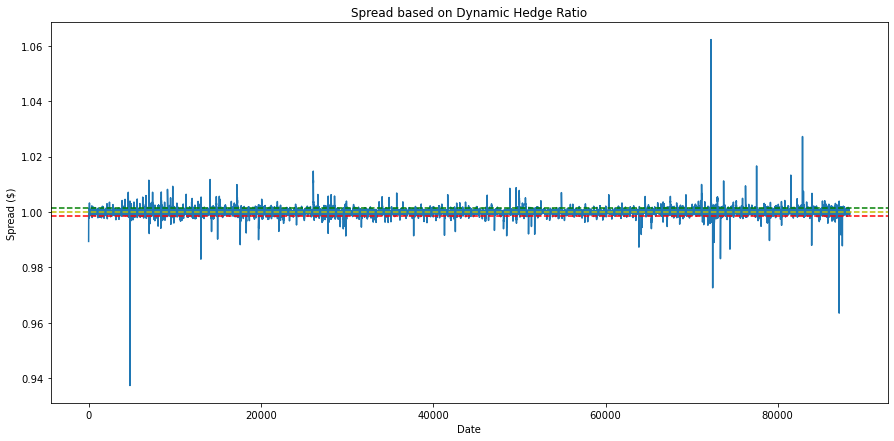

In [28]:
plt.figure(figsize = (15,7))
plt.plot(backtest_data2018['spread'])
plt.title("Spread based on Dynamic Hedge Ratio")
plt.ylabel("Spread ($)")
plt.xlabel("Date")
spread_avg = backtest_data2018['spread'].mean()
spread_sd = backtest_data2018['spread'].std()
c = 1.25
upper_threshold = spread_avg + c * spread_sd
lower_threshold = spread_avg - c * spread_sd
plt.axhline(upper_threshold, linestyle = 'dashed', color = 'g')
plt.axhline(spread_avg, linestyle = 'dashed', color = 'y')
plt.axhline(lower_threshold, linestyle = 'dashed', color = 'r')

In [29]:
print(lower_threshold, upper_threshold, spread_avg)

0.9986041977577099 1.001403455476237 1.0000038266169735


In [30]:
data.reset_index(inplace=True)
data['logspread'] = spread_ts
data['spread'] = np.exp(spread_ts)
data = data.rename(columns={'index': 'datetime'})

In [31]:
backtest_data = data[['datetime', 'qqqclose', 'hasclose', 'aaplclose', 'ttwoclose', 'sbuxclose', 
                      'ctasclose', 'alxnclose', 'algnclose', 'payxclose', 'spread']]

In [32]:
backtest_data = fn.createBars(backtest_data, lower_threshold, upper_threshold, spread_avg)

Text(0.5, 0, 'Date')

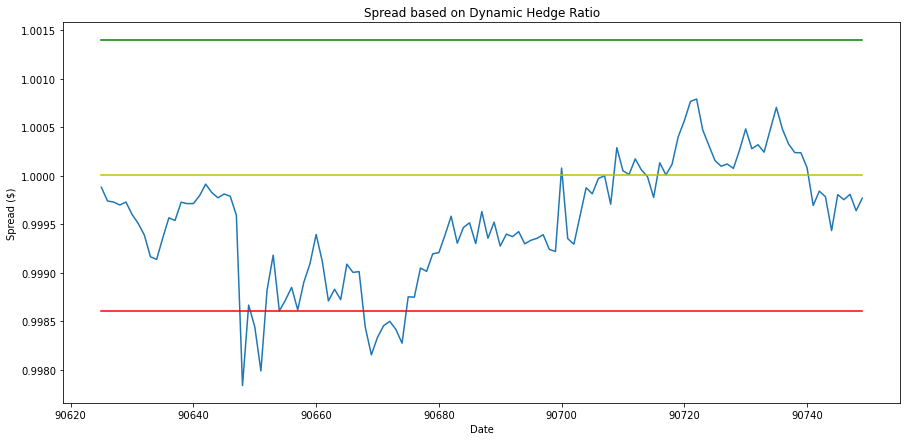

In [33]:
plt.figure(figsize = (15,7))
plt.plot(backtest_data['spread'].iloc[90625:90750])
plt.plot(backtest_data['upperband'].iloc[90625:90750], color='g')
plt.plot(backtest_data['ema'].iloc[90625:90750], color='y')
plt.plot(backtest_data['lowerband'].iloc[90625:90750], color='r')
plt.title("Spread based on Dynamic Hedge Ratio")
plt.ylabel("Spread ($)")
plt.xlabel("Date")

## Generating Signals and Positions
Description of signals, positions, how we exit at the end of the day, and the shift by 1

In [34]:
#backtest_data = fn.createPositions(backtest_data) # no overnight positions, all positions exited by EOD
#backtest_data = fn.createDerivativePositions(backtest_data)
backtest_data = fn.createOptimalPositions(backtest_data, threshold=diff_thresh)
#backtest_data = fn.createSignal(backtest_data)
#backtest_data['position'] = backtest_data['signal'].shift(1).fillna(0)

C:\Users\liuvi\anaconda3\envs\quant\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


## Trade Log
The trade log is generated to compile all the individual trades executed in our backtest and some information about them.  This includes the start and end time, the holding period, what position was taken (long or short), position size and value, as well as profit and return information.  The information in this dataset can be used to analyze the strategy and the properties of the trades executed by the strategy.

In [35]:
prices = backtest_data[['hasclose', 'aaplclose', 'ttwoclose', 'sbuxclose', 
                       'ctasclose', 'alxnclose', 'algnclose', 'payxclose']].values
hedge_ratios = np.asarray([slopes.T[i] for i in range(len(slopes.T))]).T

In [36]:
tradeLog, minuteDf = fn.constructTradeLog(backtest_data['datetime'].values, backtest_data['position'].values,
                               backtest_data['qqqclose'].values, prices, 
                               hedge_ratios.round(3), stoploss = None,
                               lot_size = 1000)
tradeLog.tail()

,start,end,holdingPeriod,position,positionSizeY,entryY,exitY,positionSizeX,entryX,exitX,initialPortfolioValue,trade_profit,trade_returns,trade_profit2
311,2019-12-18 09:54:00,2019-12-18 10:18:00,24,long,1000,209.55,209.6100,"[76.0, 248.0, 111.0, 67.0, 222.0, 97.0, 136.0,...","[102.7, 279.6399, 121.475, 88.295, 273.4318, 1...","[102.6379, 279.9, 121.63, 87.92, 271.75, 108.0...",420194.0551,374.2063,0.000891,NaN
312,2019-12-18 11:10:00,2019-12-18 11:23:00,13,short,1000,209.67,209.9799,"[76.0, 248.0, 111.0, 67.0, 221.0, 97.0, 136.0,...","[102.245, 279.66, 121.47, 87.89, 270.89, 107.9...","[102.585, 279.8999, 121.69, 88.03, 272.64, 107...",419418.5550,360.6902,0.000860,NaN
313,2019-12-18 12:32:00,2019-12-18 12:43:00,11,long,1000,209.93,209.9100,"[76.0, 248.0, 111.0, 67.0, 221.0, 97.0, 136.0,...","[102.9461, 280.9799, 122.57, 88.13, 273.405, 1...","[102.915, 280.98, 122.56, 88.15, 272.3867, 108...",420799.8514,265.5176,0.000631,NaN
314,2019-12-23 09:44:00,2019-12-23 10:33:00,48,long,1000,211.92,211.8300,"[76.0, 249.0, 111.0, 67.0, 221.0, 97.0, 136.0,...","[104.75, 281.69, 123.29, 88.6101, 270.24, 110....","[104.5828, 282.29, 123.54, 88.44, 270.615, 109...",423026.9467,-462.8291,-0.001094,NaN
315,2019-12-31 10:07:00,2019-12-31 10:37:00,28,long,1000,211.82,211.9248,"[76.0, 249.0, 111.0, 67.0, 220.0, 96.0, 136.0,...","[105.96, 290.8794, 122.36, 87.65, 269.07, 107....","[106.129, 291.5695, 121.94, 87.5953, 269.05, 1...",425082.5806,-208.7940,-0.000491,NaN


<ipython-input-37-4913ea6083e5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  returns_df['cumulative_returns'] = np.cumprod(1 + minuteDf['returns'])


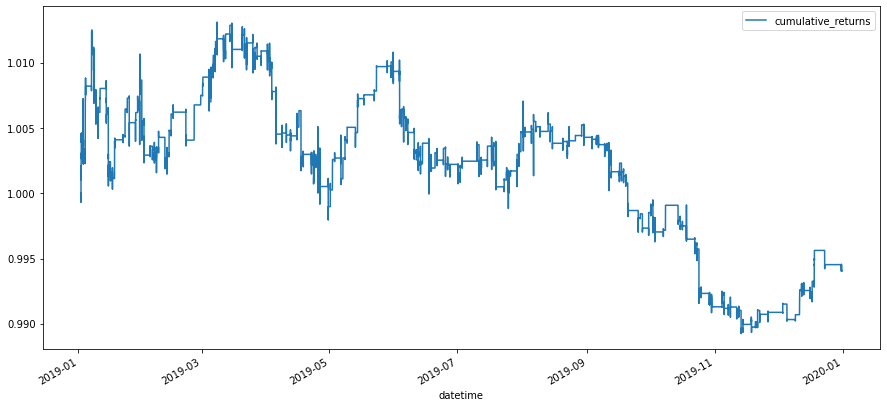

In [37]:
returns_df = minuteDf[['datetime']]
returns_df['cumulative_returns'] = np.cumprod(1 + minuteDf['returns'])
returns_df = returns_df.set_index('datetime')
returns_df.plot(figsize=[15, 7])

In [38]:
total_profit = tradeLog['trade_profit'].sum()
print('Trade Log cumulative profit was {:.3f}'.format(total_profit))

Trade Log cumulative profit was -2577.407


In [39]:
cumulative_return = np.cumprod(1 + tradeLog['trade_returns']) - 1
print('Trade Log cumulative return was {:.3f}%'.format(cumulative_return.iloc[-1] * 100))

Trade Log cumulative return was -0.580%


In [40]:
minuteDf['datetime'] = pd.to_datetime(minuteDf['datetime'])
dailyReturns = fn.calculateDailyReturns(minuteDf[['datetime', 'returns']])
sharpeRatio = fn.calculateAnnualizedSharpeRatio(dailyReturns)
print('Annualized Sharpe Ratio: ', sharpeRatio)

Annualized Sharpe Ratio:  -0.3193834783831858


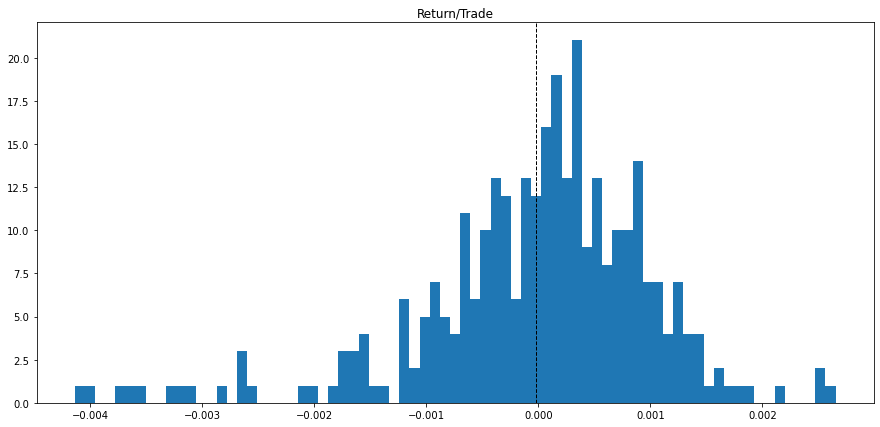

In [41]:
plt.figure(figsize=[15, 7])
plt.hist(tradeLog['trade_returns'], bins=75)
plt.axvline(tradeLog['trade_returns'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.title("Return/Trade")
plt.show()

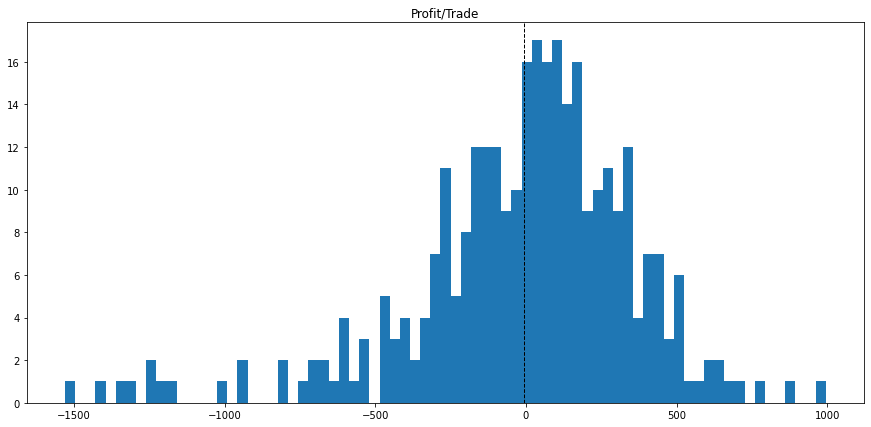

In [42]:
plt.figure(figsize=[15, 7])
plt.hist(tradeLog['trade_profit'], bins=75)
plt.axvline(tradeLog['trade_profit'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.title("Profit/Trade")
plt.show()

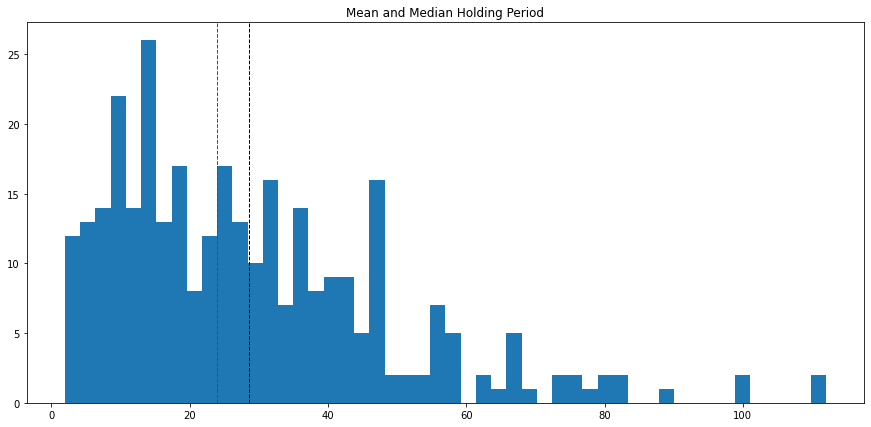

In [43]:
plt.figure(figsize=[15, 7])
plt.hist(tradeLog['holdingPeriod'], bins=50)
plt.axvline(tradeLog['holdingPeriod'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(tradeLog['holdingPeriod'].median(), color='r', linestyle='dashed', linewidth=1)
plt.title("Mean and Median Holding Period")
plt.show()